# Obtaining Statistics of the RoomNav dataset

1. Average Geodesic Distances
2. Histogram of distances vs episodes
3. Average of top-down maps
4. Lenght of oracle

2019-06-27 14:18:24,408 initializing sim Sim-v0
2019-06-27 14:18:27,144 initializing task Nav-v0


SPLIT:  train
Average Euclidean Distance:  9.285327902764505
Max Euclidean Distance:  44.632583699229166
Min Euclidean Distance:  0.5016472249430431
Average Geodesic Distance:  11.990662969581122
Max Geodesic Distance:  52.74478530883789
Min Geodesic Distance:  1.0001815557479858


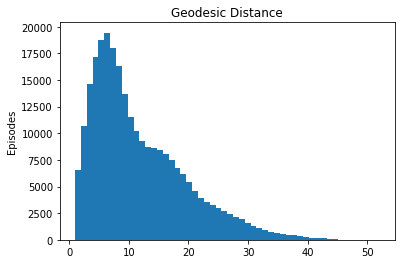

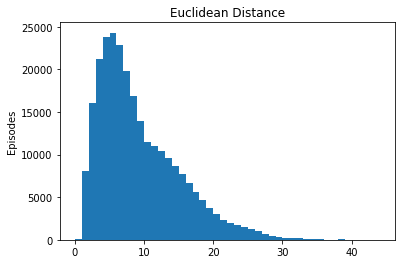

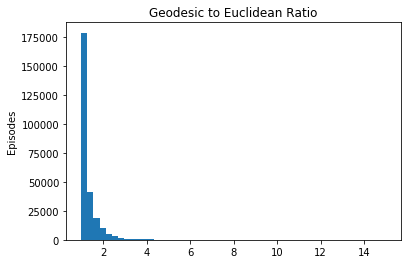

2019-06-27 14:47:51,469 initializing sim Sim-v0
2019-06-27 14:47:53,479 initializing task Nav-v0


SPLIT:  test
Average Euclidean Distance:  7.75201307150784
Max Euclidean Distance:  27.731117141146452
Min Euclidean Distance:  0.9293259274557562
Average Geodesic Distance:  9.542037117481232
Max Geodesic Distance:  31.997465133666992
Min Geodesic Distance:  1.0069078207015991


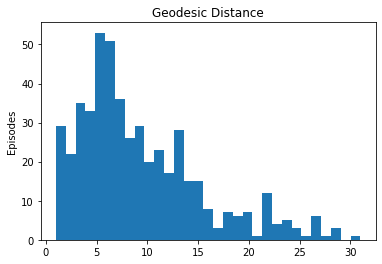

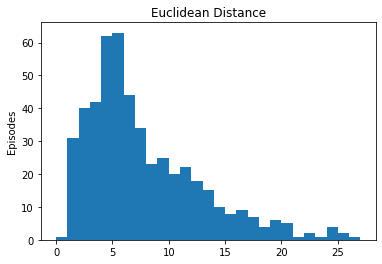

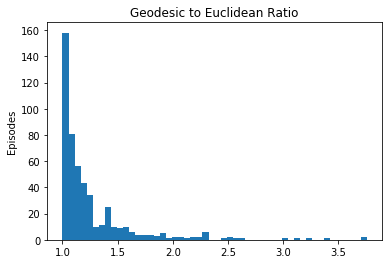

2019-06-27 14:48:45,973 initializing sim Sim-v0
2019-06-27 14:48:54,282 initializing task Nav-v0


SPLIT:  val
Average Euclidean Distance:  7.856749557637798
Max Euclidean Distance:  25.491261787609666
Min Euclidean Distance:  1.0987429240306548
Average Geodesic Distance:  10.186819750467937
Max Geodesic Distance:  31.641687393188477
Min Geodesic Distance:  1.098742961883545


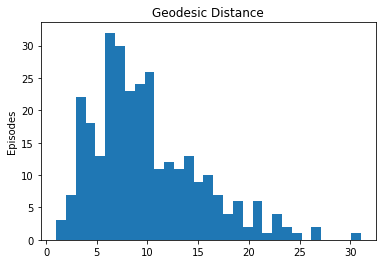

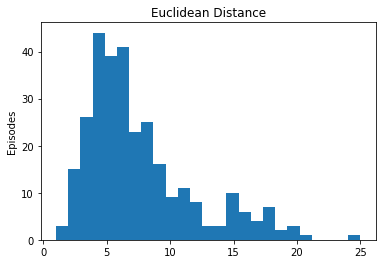

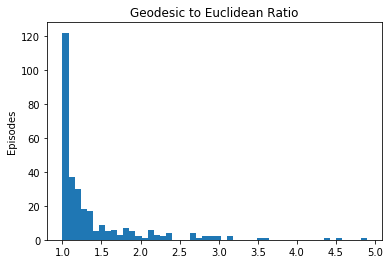

In [1]:
import habitat

import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

splits = ['train', 'test', 'val']

data_path = '../data/datasets/roomnav/mp3d/v1/{split}/{split}.json.gz'

for split in splits:
    
    avg_gd = 0
    avg_ed = 0
    min_gd = 10000000000
    max_gd = 0
    min_ed = 10000000000
    max_ed = 0
    
    gd_dists = []
    ed_dists = []
    gd2ed = []

    config = habitat.get_config(config_paths='../configs/tasks/roomnav_mp3d.yaml')
    config.defrost()
    config.DATASET.DATA_PATH = data_path.format(split=split)
    config.DATASET.SCENES_DIR = '../data/scene_datasets/'
    config.freeze()
    
    env = habitat.Env(config=config)

    for i in range(len(env.episodes)):
        observations = env.reset()
      
        sp = env.episodes[i].start_position
        tp = env.episodes[i].goals[0].position
        
        gd = env.sim.geodesic_distance(sp, tp)
        ed = np.power(np.power(np.array(sp) - np.array(tp), 2).sum(0), 0.5)
        
        gd2ed.append(gd/ed)
        gd_dists.append(gd)
        ed_dists.append(ed)

    env.close()
    
    ed_dists = np.asarray(ed_dists)
    gd_dists = np.asarray(gd_dists)
    gd2ed = np.asarray(gd2ed)
    
    print('SPLIT: ', split)
    print('Average Euclidean Distance: ', np.mean(ed_dists))
    print('Max Euclidean Distance: ', np.max(ed_dists))
    print('Min Euclidean Distance: ', np.min(ed_dists))
    
    print('Average Geodesic Distance: ', np.mean(gd_dists))
    print('Max Geodesic Distance: ', np.max(gd_dists))
    print('Min Geodesic Distance: ', np.min(gd_dists))
    
    plt.hist(gd_dists.astype(int), bins=int(np.max(gd_dists)))
    plt.title("Geodesic Distance")
    plt.ylabel('Episodes')
    plt.show()

    plt.hist(ed_dists.astype(int), bins=int(np.max(ed_dists)))
    plt.title("Euclidean Distance")
    plt.ylabel('Episodes')
    plt.show()
    
    plt.hist(np.around(gd2ed, decimals=4), bins=50)
    plt.title("Geodesic to Euclidean Ratio")
    plt.ylabel('Episodes')
    plt.show()
    

In [2]:
'''Oracle Path Lengths'''

import habitat_sim
import json
import gzip
from pydash import py_
import numpy as np
import tqdm
import glob

splits = ['train', 'test', 'val']

data_path = '../data/datasets/roomnav/mp3d/v1/{split}/{split}_all.json.gz'

for split in splits:
    with gzip.open(data_path.format(split=split), "rt") as f:
        episodes = json.load(f)["episodes"]

    act_path_lens = []
    for scene_id, eps in tqdm.tqdm(py_.group_by(episodes, "scene_id").items()):
        agent_cfg = habitat_sim.AgentConfiguration()
        sim_cfg = habitat_sim.SimulatorConfiguration()
        sim_cfg.scene.id = scene_id
        sim = habitat_sim.Simulator(
            habitat_sim.Configuration(sim_cfg, [agent_cfg])
        )

        for ep in tqdm.tqdm(eps, leave=False):
            state = sim.get_agent(0).state
            state.position = ep["start_position"]
            state.rotation = ep["start_rotation"]
            state.sensor_states = dict()

            sim.get_agent(0).state = state

            act_path_lens.append(
                len(
                    sim.make_greedy_follower().find_path(
                        ep["goals"][0]["position"]
                    )
                )
            )


    act_path_lens = np.array(act_path_lens)
    
    print('SPLIT: ', split)
    print("Min=", np.min(act_path_lens))
    print("Mean=", np.mean(act_path_lens))
    print("Median=", np.median(act_path_lens))
    print("Max=", np.max(act_path_lens))

  0%|          | 0/187500 [00:00<?, ?it/s]
                                          


AttributeError: 'Simulator' object has no attribute 'make_greedy_follower'

In [2]:
import os
import shutil

import cv2
import numpy as np

import habitat
from habitat.tasks.nav.shortest_path_follower import ShortestPathFollower
from habitat.utils.visualizations import maps

class SimpleRLEnv(habitat.RLEnv):
    def get_reward_range(self):
        return [-1, 1]

    def get_reward(self, observations):
        return 0

    def get_done(self, observations):
        return self.habitat_env.episode_over

    def get_info(self, observations):
        return self.habitat_env.get_metrics()


def draw_top_down_map(info, heading, output_size):
    top_down_map = maps.colorize_topdown_map(info["top_down_map"]["map"])
    original_map_size = top_down_map.shape[:2]
    map_scale = np.array(
        (1, original_map_size[1] * 1.0 / original_map_size[0])
    )
    new_map_size = np.round(output_size * map_scale).astype(np.int32)
    # OpenCV expects w, h but map size is in h, w
    top_down_map = cv2.resize(top_down_map, (new_map_size[1], new_map_size[0]))

    map_agent_pos = info["top_down_map"]["agent_map_coord"]
    map_agent_pos = np.round(
        map_agent_pos * new_map_size / original_map_size
    ).astype(np.int32)
    top_down_map = maps.draw_agent(
        top_down_map,
        map_agent_pos,
        heading - np.pi / 2,
        agent_radius_px=top_down_map.shape[0] / 40,
    )
    return top_down_map


def shortest_path_example(mode):
    config = habitat.get_config(config_paths="configs/tasks/roomnav_mp3d.yaml")
    config.TASK.MEASUREMENTS.append("TOP_DOWN_MAP")
    config.TASK.SENSORS.append("HEADING_SENSOR")
    env = SimpleRLEnv(config=config)
    goal_radius = env.episodes[0].goals[0].radius
    if goal_radius is None:
        goal_radius = config.SIMULATOR.FORWARD_STEP_SIZE
    follower = ShortestPathFollower(env.habitat_env.sim, goal_radius, False)
    follower.mode = mode

    print("Environment creation successful")
    for episode in range(3):
        env.reset()
        dirname = os.path.join(
            IMAGE_DIR, "shortest_path_example", mode, "%02d" % episode
        )
        if os.path.exists(dirname):
            shutil.rmtree(dirname)
        os.makedirs(dirname)
        print("Agent stepping around inside environment.")
        images = []
        while not env.habitat_env.episode_over:
            best_action = follower.get_next_action(
                env.habitat_env.current_episode.goals[0].position
            )
            observations, reward, done, info = env.step(best_action)
            im = observations["rgb"]
            top_down_map = draw_top_down_map(
                info, observations["heading"], im.shape[0]
            )
            output_im = np.concatenate((im, top_down_map), axis=1)
            images.append(output_im)
        images_to_video(images, dirname, "trajectory")
        print("Episode finished")


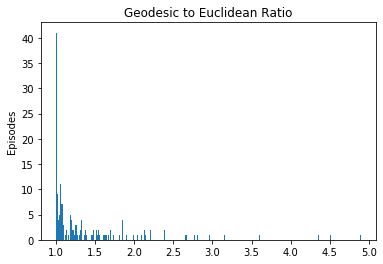

In [8]:
plt.hist(gd2ed, bins=600)
plt.title("Geodesic to Euclidean Ratio")
plt.ylabel('Episodes')
plt.show()